In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xgcm
import xmitgcm as xm
import xarray as xr

In [2]:
ds = {
    "coarsened": xr.open_dataset("/data/oceanparcels/input_data/MITgcm/ACC_channel/ACC_ridge_fine_1y_locb_coarsened.nc"),
    "coarse": xm.open_mdsdataset(
                    data_dir="/data/oceanparcels/input_data/MITgcm/ACC_channel/ACC_ridge_coarse_1y_locb/Diags",
                    grid_dir="/data/oceanparcels/input_data/MITgcm/ACC_channel/ACC_ridge_coarse_1y_locb",
                    prefix=["state", "2D_diags", "GM_diags"],
                    read_grid=True,
                    geometry="cartesian",
                    delta_t = 1000,
                    ref_date = '2000-1-1 12:0:0',
                    calendar = '360_day',
                ),
#     "fine": xm.open_mdsdataset(
#                 data_dir="/projects/0/topios/hydrodynamic_data/MITgcm/ACC_channel/ACC_ridge_fine_3y/Diags",
#                 grid_dir="/projects/0/topios/hydrodynamic_data/MITgcm/ACC_channel/ACC_ridge_fine_3y",
#                 prefix=["state", "2D_diags"],
#                 read_grid=True,
#                 geometry="cartesian",
#                 delta_t = 250,
#                 ref_date = '2000-1-1 0:0:0',
#                 calendar = '360_day',
#             )
}

In [3]:
ds["coarse_tave"] = ds["coarse"].mean(dim='time')
ds["coarsened_tave"] = ds["coarsened"].mean(dim='time')

In [4]:
computing_derivatives = ["coarse", "coarsened", "coarse_tave", "coarsened_tave"]

In [5]:
# Fix temperature in lowest row
ds["coarse"].THETA.data[:, :, 0, :] = ds["coarse"].THETA.data[:, :, 1, :]
ds["coarsened"].THETA.data[:, :, 0, :] = ds["coarsened"].THETA.data[:, :, 1, :]
ds["coarse_tave"].THETA.data[:, 0, :] = ds["coarse_tave"].THETA.data[:, 1, :]
ds["coarsened_tave"].THETA.data[:, 0, :] = ds["coarsened_tave"].THETA.data[:, 1, :]

In [6]:
for dataset in ["coarse", "coarsened", "coarse_tave", "coarsened_tave"]:
    ds[dataset]["boundaryMask"] = ds[dataset].hFacC
    ds[dataset]["boundaryMask"].data = np.where(ds[dataset]["boundaryMask"].data == 1, ds[dataset]["boundaryMask"].data * 2, ds[dataset]["boundaryMask"].data)
    ds[dataset]["boundaryMask"][:, 0, :] = 1.

In [7]:
ds["coarse"].to_netcdf("/data/oceanparcels/input_data/MITgcm/ACC_channel/ACC_ridge_coarse_1y_locb_fixtemp.nc")
ds["coarsened"].to_netcdf("/data/oceanparcels/input_data/MITgcm/ACC_channel/ACC_ridge_fine_1y_locb_coarsened_fixtemp.nc")
ds["coarse_tave"].to_netcdf("/data/oceanparcels/input_data/MITgcm/ACC_channel/ACC_ridge_coarse_1y_locb_tave_fixtemp.nc")
ds["coarsened_tave"].to_netcdf("/data/oceanparcels/input_data/MITgcm/ACC_channel/ACC_ridge_fine_1y_locb_coarsened_tave_fixtemp.nc")

In [8]:
grid = {}
for res in computing_derivatives:
    ds[res]['drW'] = ds[res].drF #vertical cell size at u point
    ds[res]['drS'] = ds[res].drF #vertical cell size at v point
    metrics = {
        ('X',): ['dxC', 'dxG','dxF', 'dxV'], # X distances
        ('Y',): ['dyC', 'dyG','dyF', 'dyU'], # Y distances
        ('Z',): ['drC', 'drF'], # Z distances
        ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw'] # Areas
    }
    Grid = xgcm.Grid(ds[res], periodic=["X"], boundary="extend", metrics=metrics)
    ds[res]['drT'] = -Grid.diff(ds[res].Z, 'Z', boundary='fill', fill_value=0) # vertical distance between cell centers
    metrics = {
        ('X',): ['dxC', 'dxG','dxF', 'dxV'], # X distances
        ('Y',): ['dyC', 'dyG','dyF', 'dyU'], # Y distances
        ('Z',): ['drW', 'drS', 'drC', 'drT'], # Z distances
        ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw'] # Areas
    }
    grid[res] = xgcm.Grid(ds[res], periodic=["X"], boundary="fill", metrics=metrics)

In [9]:
# also called strain in MITgcm
for res in computing_derivatives:
    ds[res]['r'] = (grid[res].diff(ds[res].UVEL * ds[res].dxC, 'Y') + grid[res].diff(ds[res].VVEL * ds[res].dyC, 'X'))/(ds[res].rAz)

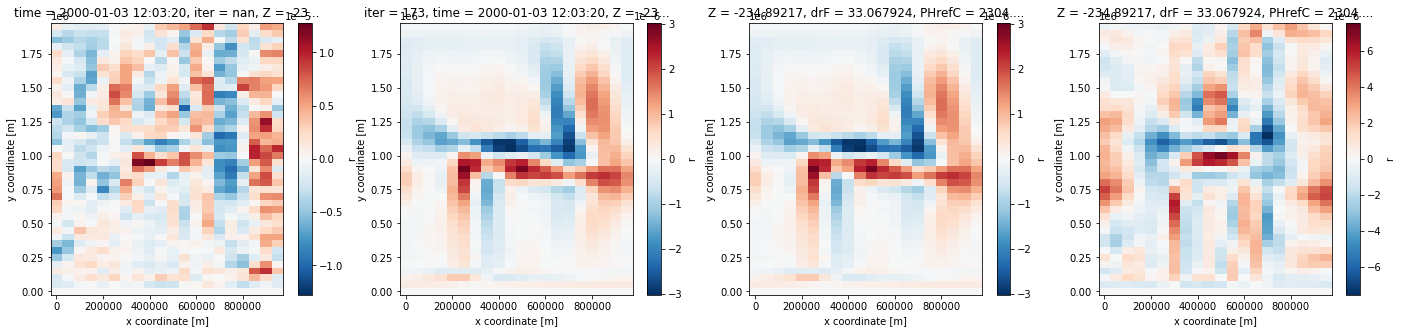

In [10]:
fig, ax = plt.subplots(ncols=4, figsize=(24,5))
for res, i in zip(ds.keys(), range(4)):
    if len(ds[res].r.dims) == 4:
        ds[res].r.isel(time=1, Z=15).plot(ax = ax[i])
    else:
        ds[res].r.isel(Z=15).plot(ax = ax[i])

In [11]:
# also called tension in MITgcm
for res in computing_derivatives:
    ds[res]['normalStrain'] = (grid[res].diff(ds[res].UVEL * ds[res].dyG, 'X') - grid[res].diff(ds[res].VVEL * ds[res].dxG, 'Y')) / ds[res].rA

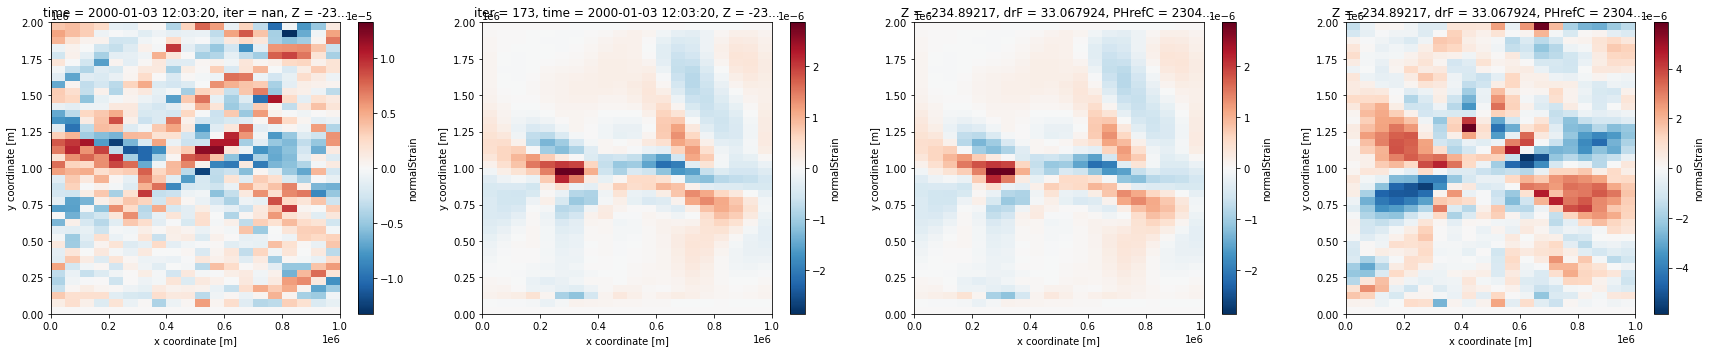

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(24,5))
for res, i in zip(ds.keys(), range(4)):
    if len(ds[res].r.dims) == 4:
        ds[res].normalStrain.isel(time=1, Z=15).plot(ax = ax[i])
    else:
        ds[res].normalStrain.isel(Z=15).plot(ax = ax[i])
plt.tight_layout()

In [13]:
for res in computing_derivatives:
    ds[res]['divergence'] = ((grid[res].diff(ds[res].UVEL * ds[res].dyG * ds[res].hFacW, 'X') + \
                             grid[res].diff(ds[res].VVEL * ds[res].dxG * ds[res].hFacS, 'Y')) / (ds[res].rA * ds[res].hFacC)).fillna(0)

/nethome/4302001/miniconda3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


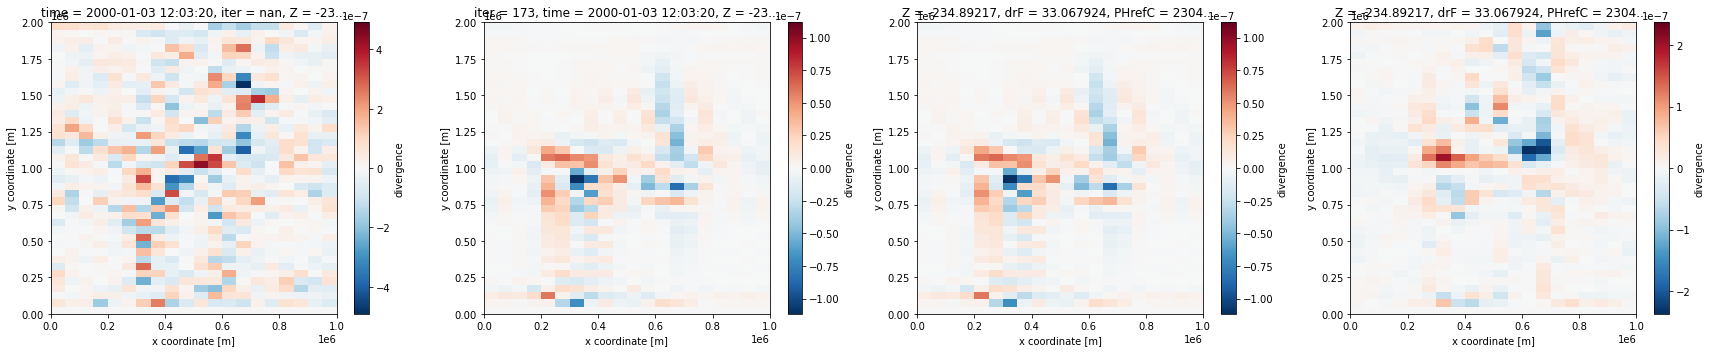

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(24,5))
for res, i in zip(ds.keys(), range(4)):
    if len(ds[res].r.dims) == 4:
        ds[res].divergence.isel(time=1, Z=15).plot(ax = ax[i])
    else:
        ds[res].divergence.isel(Z=15).plot(ax = ax[i])
plt.tight_layout()

In [15]:
for res in computing_derivatives:
    ds[res]['shearStrain_centered'] = grid[res].interp(ds[res]['r'], axis = ['X', 'Y'], to = 'center')

In [16]:
for res in computing_derivatives:
    ds[res]['p'] = np.sqrt(ds[res].shearStrain_centered**2 + ds[res].normalStrain**2) + ds[res].normalStrain
    ds[res]['q'] = np.sqrt(ds[res].shearStrain_centered**2 + ds[res].normalStrain**2) - ds[res].normalStrain
    ds[res]['delta'] = (ds[res].divergence / (np.sqrt(ds[res].shearStrain_centered**2 + ds[res].normalStrain**2))).fillna(0)

/nethome/4302001/miniconda3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


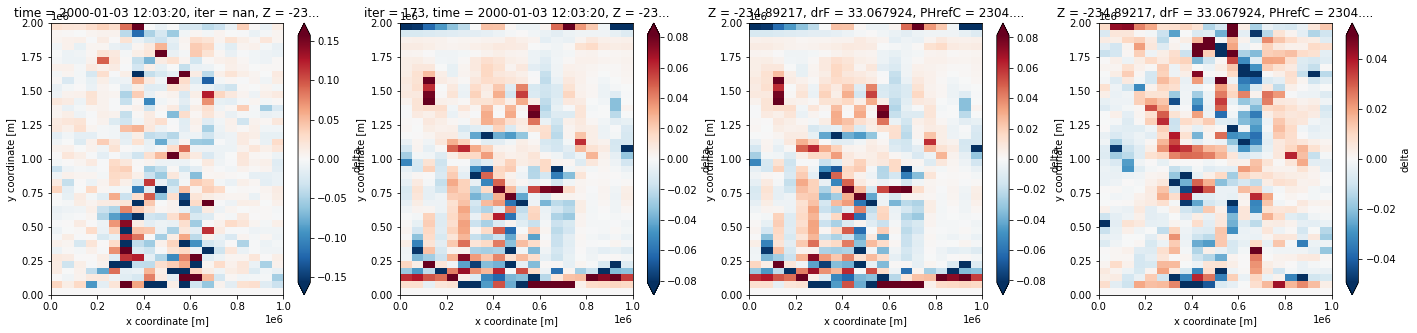

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(24,5))
for res, i in zip(ds.keys(), range(4)):
    if len(ds[res].r.dims) == 4:
        ds[res].delta.isel(time=1, Z=15).plot(ax = ax[i], robust=True)
    else:
        ds[res].delta.isel(Z=15).plot(ax = ax[i], robust=True)

In [18]:
# negatives are used since xgcm uses `drC` and `drT to determine the change in Z as the axes are traversed, but this misses a negative sign.
for res in computing_derivatives:
    for var in ['THETA', 'p', 'q', 'r', 'delta']:
        ds[res][f"d{var}dX"] = grid[res].derivative(ds[res][var], 'X', boundary='extend').fillna(0)
        ds[res][f"d{var}dY"] = grid[res].derivative(ds[res][var], 'Y', boundary='extend').fillna(0)
        ds[res][f"d{var}dZ"] = -(grid[res].diff(ds[res][var], 'Z', boundary='extend')/ds[res]['drT']).fillna(0)
        for deriv in ['X', 'Y', 'Z']:
            if var == 'THETA':
                if f"d{var}dX{deriv}" not in ds[res]:
                    ds[res][f"d{var}d{deriv}X"] = grid[res].derivative(ds[res][f"d{var}d{deriv}"], 'X', boundary='extend').fillna(0)
                if f"d{var}dY{deriv}" not in ds[res]:
                    ds[res][f"d{var}d{deriv}Y"] = grid[res].derivative(ds[res][f"d{var}d{deriv}"], 'Y', boundary='extend').fillna(0)
                if f"d{var}dZ{deriv}" not in ds[res]:
                    if deriv == 'Z':
                        ds[res][f"d{var}dZZ"] = -(grid[res].diff(ds[res][f'd{var}dZ'], 'Z', boundary='extend')/ds[res]['drF']).fillna(0)
                    else:
                        ds[res][f"d{var}d{deriv}Z"] = -(grid[res].diff(ds[res][f'd{var}d{deriv}'], 'Z', boundary='extend')/ds[res]['drT']).fillna(0)

In [19]:
ds['coarse'].to_netcdf("/data/oceanparcels/input_data/MITgcm/ACC_channel/ACC_ridge_coarse_1y_locb_fixtemp_with_derivative.nc")
ds['coarsened'].to_netcdf("/data/oceanparcels/input_data/MITgcm/ACC_channel/ACC_ridge_fine_1y_locb_coarsened_fixtemp_with_derivative.nc")
ds["coarse_tave"].to_netcdf("/data/oceanparcels/input_data/MITgcm/ACC_channel/ACC_ridge_coarse_1y_locb_tave_fixtemp_with_derivative.nc")
ds["coarsened_tave"].to_netcdf("/data/oceanparcels/input_data/MITgcm/ACC_channel/ACC_ridge_fine_1y_locb_coarsened_tave_fixtemp_with_derivative.nc")

/nethome/4302001/miniconda3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/nethome/4302001/miniconda3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


In [20]:
# ds['fine'].to_netcdf("/projects/0/topios/hydrodynamic_data/MITgcm/ACC_channel/ACC_ridge_fine_2y.nc")